<a href="https://colab.research.google.com/github/JunSeokCheon/Estimating-user-age-for-kiosk-UI-UX-personalization/blob/master/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel
from skimage.feature import canny

import time
from datetime import datetime

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
ls

drive/  sample_data/


In [ ]:
Combined_data_final_path = "/content/drive/My Drive/age_detection/zipped_dataset/Combined_data_final.zip"
try:
    os.mkdir("combined")
    os.remove("combined")
except OSError:
    pass

with ZipFile(Combined_data_final_path, 'r') as myzip:
    myzip.extractall("combined")
    print('Done unzipping Combined_data_final_path.zip')

Done unzipping Combined_data_final_path.zip


In [ ]:
Combined_data_path = '/content/combined'
Combined_data_image_names = os.listdir(Combined_data_path)

In [ ]:
len(Combined_data_image_names)

62644

In [ ]:
# combined 데이터셋을 나이, 종류(0 - facial_age, 1 - utk,  2- all-ages-face, 3 - meag)

def age_kind_split(image_name):
    image_labels = image_name.split('_')
    age = image_labels[0]
    kind = image_labels[1]

    return (age, kind)

In [ ]:
# age_kind_split 사용하여 나이, 종류 라벨을 각각 저장한다.

combined_age_labels = np.array([])
combined_kind_labels = np.array([])

for image in Combined_data_image_names:
    age, kind = age_kind_split(image)
    combined_age_labels = np.append(combined_age_labels, age)
    combined_kind_labels = np.append(combined_kind_labels, kind)

In [ ]:
combined_ages_counts = pd.Series(combined_age_labels).value_counts()
combined_ages_counts

26     2864
28     2595
24     2181
27     2177
30     1772
       ... 
116       3
91        3
101       3
115       3
103       1
Length: 94, dtype: int64

In [ ]:
combined_images = {}

for age, counts in combined_ages_counts.items():
    combined_images[int(age)] = counts

In [ ]:
combined_images[25]

1592

In [ ]:
sum(combined_images.values())

62644

In [ ]:
images_df = pd.DataFrame(combined_images.values(), index=combined_images.keys(), columns=['combined_images'])

images_df

,combined_images
26,2864
28,2595
24,2181
27,2177
30,1772
...,...
116,3
91,3
101,3
115,3


In [ ]:
images_df.fillna(0, inplace=True)
images_df = images_df.astype(int)

images_df

,combined_images
26,2864
28,2595
24,2181
27,2177
30,1772
...,...
116,3
91,3
101,3
115,3


In [ ]:
images_df.to_csv("/content/drive/My Drive/age_detection/input_output/combined_images_summary.csv", index=True, index_label='age')

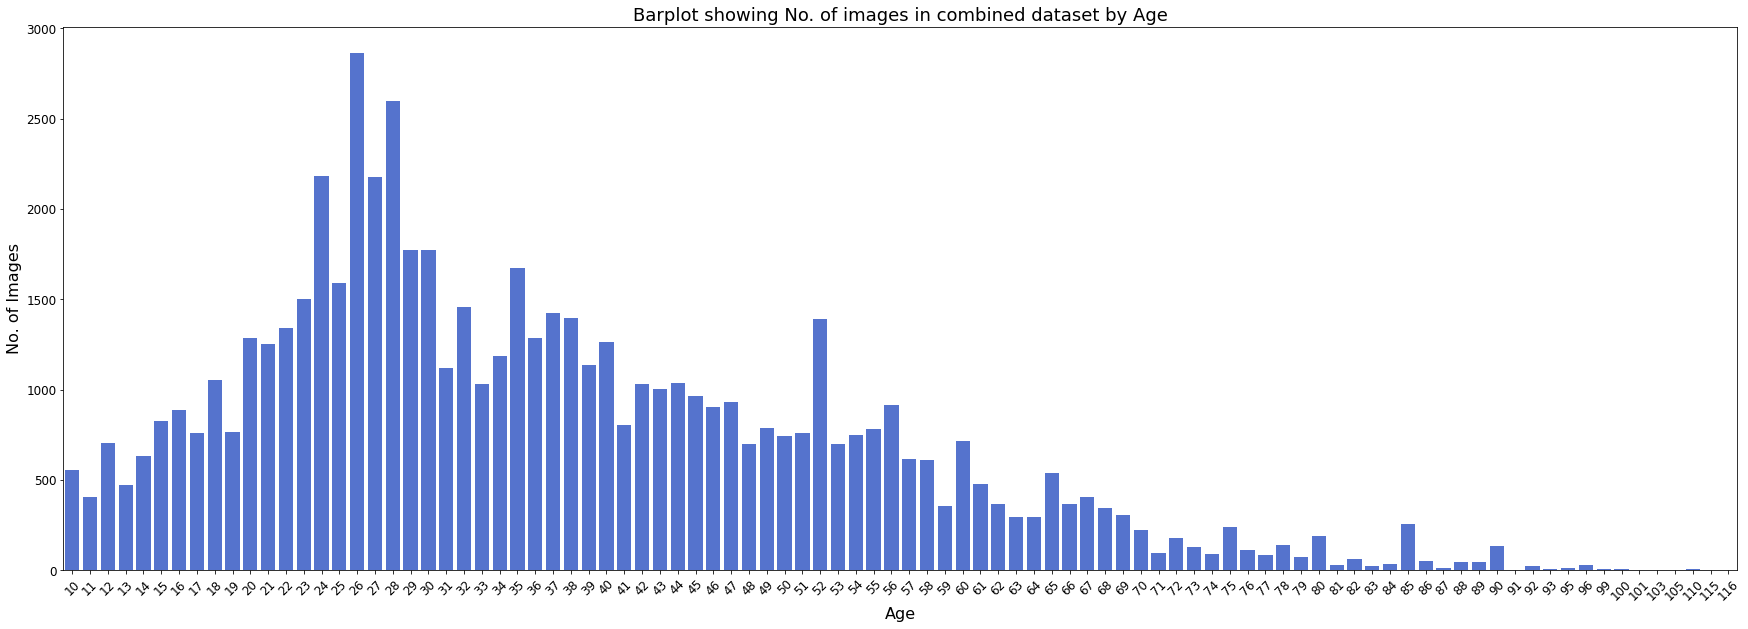

In [ ]:
plt.figure(figsize=(30, 10))

ax = sns.barplot(x=images_df.index, y=images_df['combined_images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age", fontsize=16)
plt.ylabel("No. of Images", fontsize=16)

plt.title("Barplot showing No. of images in combined dataset by Age", fontsize=18)

# png로 저장
plt.savefig('/content/drive/My Drive/age_detection/plot_images/barplot_combined_images.png', bbox_inches='tight');

In [ ]:
# 각 나이별 데이터들을 묶는데, 분류된 클래스들이 균형맞게 데이터들이 분배되어 있게 하기 위한 함수.

def split_classes(ser, n_classes):

    n_images = int(sum(ser) / n_classes)

    print(f"Total no. of images in dataset\t= {sum(ser)}")
    print(f"No. of classes desired\t\t= {n_classes}")
    print(f"So, target no. of images/class\t>= {sum(ser)}/{n_classes} = ~{n_images}")
    print()

    classes_df = pd.DataFrame(columns=['Age-ranges (classes)', 'No. of images', 'Class balance (%)'])

    age_index = 0

    for i in range(n_classes):

        if age_index<=93:
            age_start = ser.index[age_index]
            age_current = ser.index[age_index]
        else:
            break

        class_images = 0
        
        while class_images < n_images:
            class_images += ser[age_current]
            age_index += 1

            if age_index<=93:
                age_current = ser.index[age_index]
            else:
                break

        if age_index<=94:
            age_end = ser.index[age_index-1]
        else:
            break
        
        classes_df.loc[i, 'Age-ranges (classes)'] = str(age_start)+" - "+str(age_end)
        classes_df.loc[i, 'No. of images'] = class_images
        classes_df.loc[i, 'Class balance (%)'] = round((class_images / sum(ser)) * 100, 2)
    
    mean_images = int(round(np.mean(classes_df.loc[:, 'No. of images'])))
    mean_balance = round(np.mean(classes_df.loc[:, 'Class balance (%)']), 2)
    std_balance = round(np.std(classes_df.loc[:, 'Class balance (%)']), 2)
    
    print(f"Mean no. of images/class\t= ~{mean_images}")
    print(f"Mean class balance\t\t= {mean_balance}%")
    print(f"Std. of class balance\t\t= {std_balance}%")
    print()

    return classes_df

In [ ]:
combined_classes = split_classes(images_df['combined_images'], 11)
combined_classes

In [ ]:
combined_classes.to_csv("/content/drive/My Drive/age_detection/input_output/combined_faces_classes_summary.csv", index=True, index_label='Class label')

In [ ]:
plt.figure(figsize=(12, 8))

ax = sns.barplot(x=combined_classes['Age-ranges (classes)'], y=combined_classes['No. of images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)

plt.xlabel("Age-ranges (classes)", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)

plt.title("Barplot showing balance of images in different\nAge-ranges (classes) for Combined dataset", fontsize=18)

plt.savefig('/content/drive/My Drive/age_detection/plot_images/barplot_combined_faces_images_in_classes.png', bbox_inches='tight');

In [ ]:
combined_classes = pd.read_csv("/content/drive/My Drive/age_detection/input_output/combined_faces_classes_summary.csv")
combined_classes

In [ ]:
def class_labels(age):
    if 10 <= age <= 29:
        return 0
    elif 30 <= age <= 59:
        return 1 
    else:
        return 2

In [ ]:
master_df = pd.DataFrame()
master_df['filename'] = Combined_data_image_names
master_df['age'] = master_df['filename'].map(lambda img_name : np.uint8(img_name.split("_")[0]))
master_df['target'] = master_df['age'].map(class_labels)

master_df.head()

In [ ]:
master_df = shuffle(master_df, random_state=42).reset_index(drop=True)
master_df.head()

In [ ]:
temp_master = master_df.copy()

In [ ]:
combined_path = "/content/combined"

def append_path_to_filename(filename):
    return os.path.join(combined_path, filename)

In [ ]:
temp_master['filename'] = master_df['filename'].map(append_path_to_filename)

In [ ]:
temp_master.to_csv("/content/drive/My Drive/age_detection/input_output/images_filenames_labels.csv", index=False)

In [ ]:
master = pd.read_csv("/content/drive/My Drive/age_detection/input_output/images_filenames_labels.csv")
master